In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [546]:
train = pd.read_csv('./train.csv') # training set
test = pd.read_csv('./test.csv') # test set

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [547]:
# We'll use "PassengerId" as index (it'll start with 1),
# and drop the "Name" column because it makes no sense for model
train = train.set_index('PassengerId').drop('Name', axis = 1) 
# Change the values in "Sex" column ('male' = 1, 'female' = 0)
train = train.replace({'Sex' : {'male' : 1, 'female' : 0}})
# Change "Embarked" column: 'S' = 0, 'C' = 1, 'Q' = 2
train = train.replace({'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
# We also may drop the "Ticket", "Fare", and "Cabin" columns 
train = train.drop(['Ticket', 'Fare', 'Cabin'], axis = 1)

In [548]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
1,0,3,1,22.0,1,0,0.0
2,1,1,0,38.0,1,0,1.0
3,1,3,0,26.0,0,0,0.0
4,1,1,0,35.0,1,0,0.0
5,0,3,1,35.0,0,0,0.0
...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,0.0
888,1,1,0,19.0,0,0,0.0
889,0,3,0,NaN,1,2,0.0


# 1. Train our model

We will try two models:  

1. *Linear logistic regression*  
2. *Two-layer neural network*  

Choose the one, who will perform better on training set prediction

# 2. Linear logistic regression

So we have 7 features, and 891 training examples:  

* Pclass - Passenger class (3 - lowest, 1 - highest)
* Sex
* Age
* SibSp - # of siblings / spouses aboard the Titanic
* Parch - # of parents / children aboard the Titanic
* Embarked - Port of Embarkation (0 = Southampton, 1 = Cherbourg, 2 = Queenstown)  

Our label vector is *Survived* column  

Let's prepare our data for model

In [549]:
# It's necessary to implement normalization of "Age" column
mean_age = train.Age.mean()
age_deviation = train.Age.std()
train.Age = (train.Age - mean_age)/(age_deviation + 10**(-8))
# And we will repalce NaN ages with its average value
train.Age = train.Age.fillna(train.Age.mean())
# Alse we need to fill NaN Embarked positions
# I fill with 2, (assume that these passengers were the last who went on the ship)
train.Embarked = train.Embarked.fillna(2)

train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
1,0,3,1,-5.300051e-01,1,0,0.0
2,1,1,0,5.714304e-01,1,0,1.0
3,1,3,0,-2.546462e-01,0,0,0.0
4,1,1,0,3.649113e-01,1,0,0.0
5,0,3,1,3.649113e-01,0,0,0.0
...,...,...,...,...,...,...,...
887,0,2,1,-1.858065e-01,0,0,0.0
888,1,1,0,-7.365243e-01,0,0,0.0
889,0,3,0,2.388379e-16,1,2,0.0


In [550]:
data_train = train.to_numpy()

In [551]:
data_train

array([[0., 3., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 3., 0., ..., 0., 0., 0.],
       ...,
       [0., 3., 0., ..., 1., 2., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [0., 3., 1., ..., 0., 0., 2.]])

In [552]:
# The first column in numpy array is label vector Y_train
Y_train = data_train[:, :1]
X_train = data_train[:, 1:] # drop the label column out of thraining set
Y_train[0:5]

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.]])

In [553]:
def initialize_parameters_regr(n, null = False):
    
    # Initialize parameters for Logistic Regression model
    # W - weights, b - bias unit, (W.shape == (n, 1))
    # If null == false W and b are gaussian distributed random variable with mean == 0 and variance == 1
    # else W and b are zeros
    # n - number of features
    # return parameters = {'W' : W_values, 'b' : b_value}
    
    parameters = dict()
    
    parameters['W'] = np.random.randn(n, 1)
    parameters['b'] = np.random.randn()
    
    if null is True:
        parameters['W'] = 0 * parameters['W']
        parameters['b'] = 0 * parameters['b']
    
    return parameters

In [554]:
parameters_test = initialize_parameters_regr(2, null = True)
parameters_test

{'W': array([[ 0.],
        [-0.]]),
 'b': 0.0}

In [555]:
def sigmoid(Z):
    
    return 1 / (1 + np.exp(-Z))

In [556]:
sigmoid(0)

0.5

In [557]:
def compute_cost_regr(X, Y, parameters, lambd = 0):
    
    # Compute cost and gradients
    # grads - dictionary with gradients
    # return cost, grads
    
    W = parameters['W']
    b = parameters['b']
    m = X.shape[0]
    cost = 0
    grads = dict()
    
    Z = np.dot(X, W) + b
    A = sigmoid(Z)
    
    # Cross-entropy cost function
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) + lambd/(2*m) * np.sum(W**2)
    
    grads['W'] = 1/m * np.dot(X.T, A-Y) + lambd/m * W
    grads['b'] = 1/m * np.sum(A - Y)
    
    return cost, grads

In [558]:
def update_parameters_regr(parameters, grads, learning_rate = 0.001):
    
    parameters['W'] = parameters['W'] - learning_rate * grads['W']
    parameters['b'] = parameters['b'] - learning_rate * grads['b']
    
    return parameters

In [559]:
def model_regr(X, Y, num_iterations = 15000, learning_rate = 0.01, lambd = 0, null = False, plot_cost = False):
    
    (m, n) = X.shape
    parameters = initialize_parameters_regr(n, null)
    costs = list()
    
    for i in range(num_iterations):
        
        cost, grads = compute_cost_regr(X, Y, parameters, lambd)
        if i % 100 == 0:
            costs.append(cost)  
        parameters = update_parameters_regr(parameters, grads, learning_rate)
        
        if i % 1000 == 0:
            print('Cost after {} iterations: {}'.format(i, cost))
    
    if plot_cost is True:
        plt.plot(costs)
        plt.title('Cost with learning rate = {}, lambda = {}, num iter = {}'.format(learning_rate, lambd, num_iterations))
        plt.xlabel('iterations (per 100)')
        plt.ylabel('Cost')
        plt.show()
    
    
    return parameters

In [560]:
def prediction_regr(X, Y, parameters):
    
    W = parameters['W']
    b = parameters['b']
    
    Z_pred = np.dot(X, W) + b
    A_pred = sigmoid(Z_pred)
    Y_pred = np.round(A_pred)
    
    pred = np.mean(Y_pred == Y) * 100
    
    return pred, Y_pred

Cost after 0 iterations: 0.6931471805599454
Cost after 1000 iterations: 0.5477219173243725
Cost after 2000 iterations: 0.5147861504193557
Cost after 3000 iterations: 0.4960650822018183
Cost after 4000 iterations: 0.48354510371754295
Cost after 5000 iterations: 0.47453590517571304
Cost after 6000 iterations: 0.46779048099185916
Cost after 7000 iterations: 0.4626146303929533
Cost after 8000 iterations: 0.45857637655311756
Cost after 9000 iterations: 0.45538679676342386
Cost after 10000 iterations: 0.4528431448744169
Cost after 11000 iterations: 0.4507984354973897
Cost after 12000 iterations: 0.449143636628675
Cost after 13000 iterations: 0.4477964822184869
Cost after 14000 iterations: 0.446694066098835


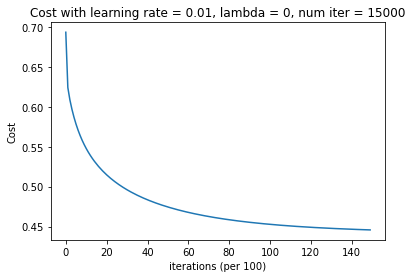

## Linear logistic regression ##

ACCURACY ON TRAINING SET   80.13468013468014 %


{'W': array([[-0.92064409],
        [-2.34795812],
        [-0.46536779],
        [-0.25585496],
        [ 0.00434963],
        [ 0.33606607]]),
 'b': 2.9860506482969975}

In [561]:
parameters_regr = model_regr(X_train, Y_train, null = True, plot_cost = True)
pred, _ = prediction_regr(X_train, Y_train, parameters_regr)
print('## Linear logistic regression ##\n')
print('ACCURACY ON TRAINING SET   {} %'.format(pred))
parameters_regr

# 3. Neural Network

As it was mentioned before, we will use two-layer neural network  
with 7 hidden units and 1 output unit.  

All activation functions will be sigmoids.  

So data has been prepared earlier, let's start.

In [562]:
def initialize_parameters_nn(dims):
    
    # Initialize parameters for Neural Network model
    # Wi - weights of ith layer, bi - bias unit of ith layer, (Wi.shape == (dims[i], 1))
    # W and b are gaussian distributed random variable with mean == 0 and variance == 1
    # L - number of layers
    # dims - list of dimensions of each layer (dims[0] == number of features)
    # return parameters = {'Wi' : Wi_values, 'bi' : bi_value}
    
    L = len(dims) - 1
    parameters = dict()
    
    for l in range(L):
        parameters['W' + str(l+1)] = np.random.randn(dims[l+1], dims[l]) * 0.01
        parameters['b' + str(l+1)] = np.zeros((dims[l + 1], 1))
        
    return parameters, L

In [563]:
parameters_test = initialize_parameters_nn([1,1,1])
parameters_test

({'W1': array([[0.00096876]]),
  'b1': array([[0.]]),
  'W2': array([[-0.01873558]]),
  'b2': array([[0.]])},
 2)

In [564]:
def forward_propagation(X, L, parameters):
    
    # Implement forward propagation
    # return cache = {'Zi' = Zi_value, 'Ai' = Ai_value} 
    
    cache = dict()
    cache['A0'] = X.T
    cache['Z0'] = X.T
    
    for l in range(L):
        cache['Z' + str(l+1)] = np.dot(parameters['W' + str(l+1)], cache['Z' + str(l)]) + parameters['b' + str(l+1)]
        cache['A' + str(l+1)] = sigmoid(cache['Z' + str(l+1)])
        
    return cache

In [565]:
def compute_cost_nn(A, Y, L, parameters, lambd):
    
    m = A.shape[1]
    W = 0
    for l in range(L):
        W = W + np.sum(parameters['W' + str(l + 1)]**2 )
    
    cost = -1/m * np.sum(Y.T * np.log(A) + (1 - Y.T)*np.log(1-A)) + lambd/(2*m) * W
    
    return cost

In [566]:
def backward_propagation(Y, cache, L, parameters, lambd):
    
    # Implement backward propagation
    # return grads = {'dZi' = dZi_value, 'dWi' = dWi_value, 'dbi' = dbi_value}
    
    grads = dict()
    m = cache['A' + str(L)].shape[1]
    grads['dZ' + str(L)] = cache['A' + str(L)] - Y.T
    grads['dW' + str(L)] = 1/m * np.dot(grads['dZ' + str(L)], cache['A' + str(L-1)].T) + lambd/m * parameters['W' + str(L)]
    grads['db' + str(L)] = 1/m * np.sum(grads['dZ' + str(L)], axis = 1, keepdims = True)
    
    for l in range(L - 1, 0, -1):
        grads['dZ' + str(l)] = 1/m * np.dot(parameters['W'+str(l+1)].T, grads['dZ'+str(l+1)])*cache['A' + str(l)]*(1-cache['A' + str(l)])
        grads['dW' + str(l)] = 1/m * np.dot(grads['dZ' + str(l)], cache['A' + str(l-1)].T) + lambd/m * parameters['W' + str(l)]
        grads['db' + str(l)] = 1/m * np.sum(grads['dZ' + str(l)], axis = 1, keepdims = True)
        
    return grads

In [567]:
def update_parameters_nn(parameters, grads, learning_rate, L):
    
    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        
    return parameters

In [568]:
def model_nn(X, Y, dims, num_iterations = 15000, learning_rate = 0.01, lambd = 0, plot_cost = False):
    
    parameters, L = initialize_parameters_nn(dims)
    costs = list()
    
    for i in range(num_iterations):
        
        cache = forward_propagation(X, L, parameters)
        A = cache['A' + str(L)]
        cost = compute_cost_nn(A, Y, L, parameters, lambd)
        if i % 100 == 0:
            costs.append(cost)
        grads = backward_propagation(Y, cache, L, parameters, lambd)
        parameters = update_parameters_nn(parameters, grads, learning_rate, L)
        
        if i % 1000 == 0:
            print('Cost after {} iterations: {}'.format(i, cost))
    
    if plot_cost is True:
        plt.plot(costs)
        plt.title('Cost with learning rate = {}, lambda = {}, num iter = {}'.format(learning_rate, lambd, num_iterations))
        plt.xlabel('iterations (per 100)')
        plt.ylabel('Cost')
        plt.show()
    
    
    return parameters

In [569]:
def prediction_nn(X, Y, L, parameters):
    
    cache = forward_propagation(X, L, parameters)
    Y_pred = np.round(cache['A' + str(L)]).T
    
    pred = np.mean(Y_pred == Y) * 100
    
    return pred, Y_pred

Cost after 0 iterations: 0.6930766797274847
Cost after 1000 iterations: 0.6653382765438225
Cost after 2000 iterations: 0.6645419621804614
Cost after 3000 iterations: 0.6636354876832175
Cost after 4000 iterations: 0.6625334177509414
Cost after 5000 iterations: 0.6611404087348083
Cost after 6000 iterations: 0.6593462422679426
Cost after 7000 iterations: 0.6570226049206046
Cost after 8000 iterations: 0.6540224847458241
Cost after 9000 iterations: 0.6501835632092021
Cost after 10000 iterations: 0.6453372759494098
Cost after 11000 iterations: 0.6393249828251717
Cost after 12000 iterations: 0.6320215086759995
Cost after 13000 iterations: 0.6233638905436484
Cost after 14000 iterations: 0.6133797453524771


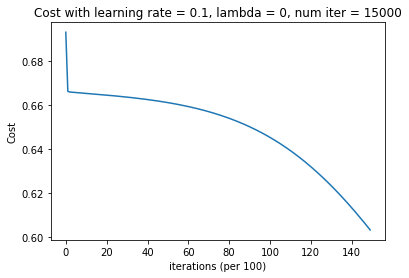

## Neural Network ##

ACCURACY ON TRAINING SET   67.11560044893379 %


{'W1': array([[ 0.04393113,  0.04469165, -0.00437501, -0.00019126,  0.00125889,
         -0.01891928],
        [ 0.03614539,  0.02645722,  0.00977662, -0.00135213, -0.01296449,
         -0.00027209],
        [-0.03319923, -0.01980846, -0.00136029, -0.01472511,  0.01279134,
         -0.00654465],
        [-0.01026498,  0.00990358, -0.00017932, -0.01097168,  0.00748585,
         -0.00959384],
        [ 0.01283535,  0.02733779,  0.00657   ,  0.00753162,  0.00633819,
          0.00063017],
        [ 0.01515329,  0.01731051,  0.00506937, -0.00627436, -0.00817532,
         -0.00325444],
        [ 0.04840304,  0.03994258,  0.01383287,  0.00635678, -0.03105321,
         -0.02310145]]),
 'b1': array([[-2.75028890e-04],
        [-1.77411252e-04],
        [ 1.80125386e-04],
        [ 2.12497140e-05],
        [-8.89705719e-05],
        [-7.13518172e-05],
        [-3.26722408e-04]]),
 'W2': array([[-1.63118887, -1.14911759,  1.29258175,  0.20517404, -0.63542112,
         -0.5119504 , -1.90425368]])

In [570]:
dims = [X_train.shape[1], 7, 1]
L = len(dims) - 1
parameters_nn = model_nn(X_train, Y_train, dims, plot_cost = True, learning_rate = 0.1)
pred, _ = prediction_nn(X_train, Y_train, L, parameters_nn)
print('## Neural Network ##\n')
print('ACCURACY ON TRAINING SET   {} %'.format(pred))
parameters_nn

# 4. Result

As we see logistic regression is far more efficient, so we will use it for the submission

In [571]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [572]:
# Drop the "Name" column because it makes no sense for model
test = test.drop('Name', axis = 1) 
# Change the values in "Sex" column ('male' = 1, 'female' = 0)
test = test.replace({'Sex' : {'male' : 1, 'female' : 0}})
# Change "Embarked" column: 'S' = 0, 'C' = 1, 'Q' = 2
test = test.replace({'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
# We also may drop the "Ticket", "Fare", and "Cabin" columns 
test = test.drop(['Ticket', 'Fare', 'Cabin'], axis = 1)

In [573]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,1,34.5,0,0,2
1,893,3,0,47.0,1,0,0
2,894,2,1,62.0,0,0,2
3,895,3,1,27.0,0,0,0
4,896,3,0,22.0,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,0
414,1306,1,0,39.0,0,0,1
415,1307,3,1,38.5,0,0,0
416,1308,3,1,NaN,0,0,0


In [574]:
test.Embarked = test.Embarked.fillna(2)
test.Age = (test.Age.fillna(mean_age) - mean_age) / (age_deviation + 10**(-8))

In [575]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,1,0.330491,0,0,2
1,893,3,0,1.190988,1,0,0
2,894,2,1,2.223584,0,0,2
3,895,3,1,-0.185807,0,0,0
4,896,3,0,-0.530005,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,1,0.000000,0,0,0
414,1306,1,0,0.640270,0,0,1
415,1307,3,1,0.605850,0,0,0
416,1308,3,1,0.000000,0,0,0


In [576]:
pred, Y_subm = prediction_regr(test.loc[:, 'Pclass' : 'Embarked'], np.zeros((418, 1)), parameters_regr)
Y_subm[0:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [577]:
test['Survived'] = Y_subm

In [579]:
test.set_index('PassengerId')['Survived'].astype('int').to_csv('./new_subm.csv')